# Horse Racing

This script downloads horse racing data and models races in order to predict future horse racing reuslts. This is an exploratory analysis, and does not feature any hyperparameter optimisation and largely demonstrates an ability to model data and fit conventional models, and evaluate the results.

In [1]:
#import statements
import os
import pandas as pd
import kagglehub
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import calibration_curve

# Data Wrangling

The following code imports data from Kaggle and processes it into the required format for modeling with a Random Forest. As part of the analysis, several features were engineered, including the maximum rating and average rating of other horses in the race. These additional features help capture race dynamics and improve model efficiency by speeding up training. Since this is an exploratory analysis, I opted to drop all races with missing data rather than applying advanced imputation methods.

I also filter the dataset to make the horse racing modelled on flat races, a mile long and only modelling group 1, 2 and 3 races for simplicity.

In [2]:
# importing data in
# # Download latest version
# path = kagglehub.dataset_download("hwaitt/horse-racing")
# Set working directory
home_dir = r"C:\Users\Sam\.cache\kagglehub\datasets\hwaitt\horse-racing\versions\3"
os.chdir(home_dir)

In [3]:
# Function to load and merge CSVs
def load_and_merge(file_prefix, years):
    dfs = []
    for year in years:
        file_name = f"{file_prefix}_{year}.csv"
        if file_name in os.listdir(home_dir):
            df = pd.read_csv(file_name)
            df["year"] = year
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load the datasets
years = range(1990, 2020)
horses = load_and_merge("horses", years)
races = load_and_merge("races", years)

horse_races = horses.merge(races.drop(columns=["year"]), on="rid", how="left")

horse_races["sample"] = horse_races["year"].apply(lambda x: "Train" if x < 2019 else "Test")
display(horse_races)

<ipython-input-3-c7a5c1887dad>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,sample
0,271018,Combermere,6.0,0.0,0.222222,0,R G Frost,J Frost,1,NaN,...,Soft,19 fences,"[2922.5, 875.0, 420.0, 192.5]",398.3,4409.0,5028.0,GB,5,0,Train
1,271018,Royal Battery,6.0,0.0,0.090909,0,D H Barons,S Earle,2,10,...,Soft,19 fences,"[2922.5, 875.0, 420.0, 192.5]",398.3,4409.0,5028.0,GB,5,0,Train
2,271018,Just So,7.0,0.0,0.029412,0,J D Roberts,S Burrough,3,15,...,Soft,19 fences,"[2922.5, 875.0, 420.0, 192.5]",398.3,4409.0,5028.0,GB,5,0,Train
3,271018,Mandraki Shuffle,8.0,0.0,0.090909,0,Oliver Sherwood,M Richards,4,20,...,Soft,19 fences,"[2922.5, 875.0, 420.0, 192.5]",398.3,4409.0,5028.0,GB,5,0,Train
4,271018,Turnberry Dawn,8.0,0.0,0.047619,0,T B Hallett,P Richards,5,dist,...,Soft,19 fences,"[2922.5, 875.0, 420.0, 192.5]",398.3,4409.0,5028.0,GB,5,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957797,57679,Agentleman,9.0,9.0,0.111111,0,Peter Winks,Kane Yeoman,7,.5,...,Soft,12 fences,"[3898.8, 1144.8, 572.4, 350.0, 350.0, 350.0, 3...",259.0,7366.0,3218.0,GB,5,5,Test
3957798,57679,Joly Maker,5.0,2.0,0.111111,0,Jonjo O'Neill,Richie McLernon,8,6,...,Soft,12 fences,"[3898.8, 1144.8, 572.4, 350.0, 350.0, 350.0, 3...",259.0,7366.0,3218.0,GB,5,5,Test
3957799,57679,Hume Lough,8.0,10.0,0.038462,0,Sarah-Jayne Davies,Charlie Hammond,40,NaN,...,Soft,12 fences,"[3898.8, 1144.8, 572.4, 350.0, 350.0, 350.0, 3...",259.0,7366.0,3218.0,GB,5,5,Test
3957800,57679,Comber Mill,7.0,1.0,0.181818,0,Alastair Ralph,Liam Treadwell,40,NaN,...,Soft,12 fences,"[3898.8, 1144.8, 572.4, 350.0, 350.0, 350.0, 3...",259.0,7366.0,3218.0,GB,5,5,Test


In [4]:
#data cleaning
df = horse_races.copy()
df = df[df['hurdles'].isna()]

def fill_nan_with_zero(value):
    if pd.isna(value):
        return 0
    return int(value)

def convert_to_km(distance):
    miles = 0
    furlongs = 0
    
    mile_match = re.search(r'(\d+)m', distance)
    furlong_match = re.search(r'(\d+)½?f', distance)

    if mile_match:
        miles = int(mile_match.group(1)) * 1.60934

    if furlong_match:
        furlong_value = furlong_match.group(1)
        if '½' in distance:
            furlongs = int(furlong_value) * 0.201168 + 0.100584
        else:
            furlongs = int(furlong_value) * 0.201168

    return round(miles + furlongs, 2)

def extract_grade(value):
    if pd.isna(value) or len(value) < 7:
        return np.nan
    try:
        return int(value[6])
    except ValueError:
        return np.nan

df['outHandicap'] = df['outHandicap'].apply(fill_nan_with_zero)
df['avgRPR'] = df.groupby('rid')['RPR'].transform(lambda x: (x.sum() - x) / (x.count() - 1))
df['maxRPR'] = df.groupby('rid')['RPR'].transform(lambda x: x.loc[x.index != x.idxmax()].max() if len(x) > 1 else None)
df['count'] = df['runners']
df['dist'] = df['distance'].apply(convert_to_km)
df['grade'] = df['rclass'].apply(extract_grade)
df['win'] = df['res_win']
df = df[['rid', 'age', 'outHandicap', 'avgRPR', 'maxRPR', 'count', 'dist', 'grade', 'win', 'decimalPrice', 'sample']]
df = df[df['dist'] == 1.61]
df = df[df['grade'] <= 3]


In [5]:
incomplete_races = df[df.isnull().any(axis=1)]['rid'].unique()
cleaned_df = df[~df['rid'].isin(incomplete_races)]
print(f"Removed {len(df) - len(cleaned_df)} rows due to incomplete races.")

Removed 10996 rows due to incomplete races.


# Model fitting

The following code fits a random forest with default parameters to the training data, setting a seed for reproducability.

In [6]:
seed = 64
np.random.seed(seed)
random.seed(seed)

In [7]:
# train/test
train_data = cleaned_df[cleaned_df['sample'] == 'Train'].copy()
test_data = cleaned_df[cleaned_df['sample'] == 'Test'].copy()
display(train_data)

# feature definition
excluded_columns = ['sample', 'win', 'rid']  # Exclude non-feature columns
features = [col for col in cleaned_df.columns if col not in excluded_columns]

# train/ test
X_train, y_train = train_data[features], train_data['win'].astype(int)
X_test, y_test = test_data[features], test_data['win'].astype(int)

# train model
rf_model = RandomForestClassifier(random_state=seed, n_jobs=-1)  # Default parameters
rf_model.fit(X_train, y_train)

# predictions
y_pred = rf_model.predict(X_test)

,rid,age,outHandicap,avgRPR,maxRPR,count,dist,grade,win,decimalPrice,sample
104217,363947,3.0,0,88.50,91.0,5,1.61,2.0,1.0,0.222222,Train
104218,363947,3.0,0,88.75,91.0,5,1.61,2.0,0.0,0.333333,Train
104219,363947,3.0,0,88.75,91.0,5,1.61,2.0,0.0,0.111111,Train
104220,363947,3.0,0,90.00,91.0,5,1.61,2.0,0.0,0.125000,Train
104221,363947,3.0,0,90.00,91.0,5,1.61,2.0,0.0,0.285714,Train
...,...,...,...,...,...,...,...,...,...,...,...
3785931,66779,6.0,0,91.00,96.0,6,1.61,2.0,0.0,0.105263,Train
3785932,66779,7.0,0,91.00,96.0,6,1.61,2.0,0.0,0.052632,Train
3785933,66779,3.0,0,93.40,96.0,6,1.61,2.0,0.0,0.142857,Train
3785934,66779,4.0,0,93.60,96.0,6,1.61,2.0,0.0,0.181818,Train


# Model evaluation

The following code evaluates model performance, showing accuracy, recall, F1 score, feature importance, calibration and the profit and loss associated with a conventional betting strategy of betting when the probability is 20% higher than the market probability.

Accuracy: 0.8841
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      1658
           1       0.47      0.07      0.11       215

    accuracy                           0.88      1873
   macro avg       0.68      0.53      0.53      1873
weighted avg       0.84      0.88      0.84      1873



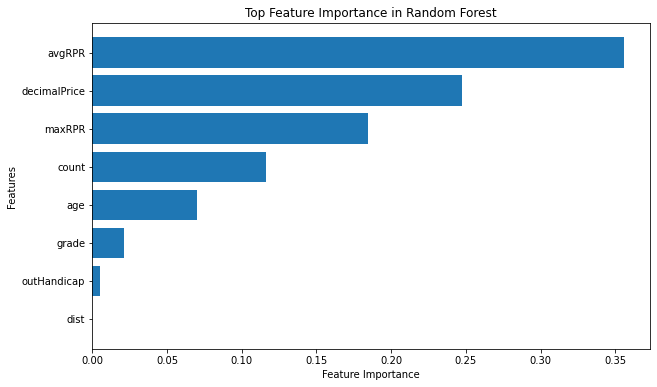

In [8]:
# model evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

In [9]:
rf_probs = rf_model.predict_proba(X_test)[:, 1]
comparison_df = test_data.copy()
comparison_df['rf_probability'] = rf_probs
display(comparison_df)

,rid,age,outHandicap,avgRPR,maxRPR,count,dist,grade,win,decimalPrice,sample,rf_probability
3787229,111237,6.0,0,79.714286,94.0,8,1.61,3.0,1.0,0.250000,Test,0.550
3787230,111237,5.0,0,81.000000,94.0,8,1.61,3.0,0.0,0.222222,Test,0.160
3787231,111237,4.0,0,80.285714,94.0,8,1.61,3.0,0.0,0.400000,Test,0.500
3787232,111237,8.0,0,81.571429,94.0,8,1.61,3.0,0.0,0.090909,Test,0.040
3787233,111237,4.0,0,82.285714,94.0,8,1.61,3.0,0.0,0.090909,Test,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...
3956044,82385,3.0,0,75.666667,92.0,7,1.61,2.0,0.0,0.222222,Test,0.320
3956045,82385,3.0,4,78.500000,92.0,7,1.61,2.0,0.0,0.038462,Test,0.150
3956046,82385,3.0,0,75.833333,92.0,7,1.61,2.0,0.0,0.285714,Test,0.305
3956047,82385,4.0,6,80.833333,92.0,7,1.61,2.0,0.0,0.034483,Test,0.100


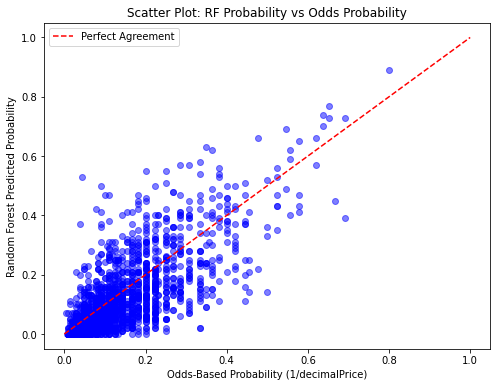

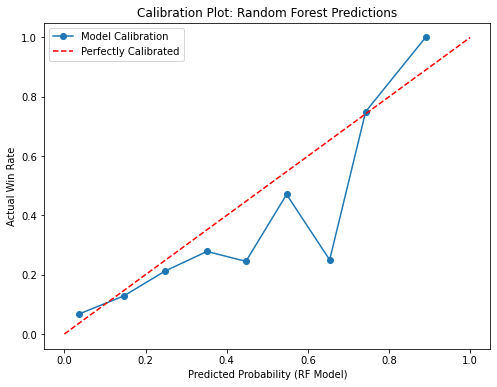

In [10]:
# Scatter Plot: Comparing Model and Odds-Based Probabilities
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['decimalPrice'], comparison_df['rf_probability'], alpha=0.5, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label="Perfect Agreement")
plt.xlabel("Odds-Based Probability (1/decimalPrice)")
plt.ylabel("Random Forest Predicted Probability")
plt.title("Scatter Plot: RF Probability vs Odds Probability")
plt.legend()
plt.show()

# Calibration Plot
prob_true, prob_pred = calibration_curve(comparison_df['win'], comparison_df['rf_probability'], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label="Model Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability (RF Model)")
plt.ylabel("Actual Win Rate")
plt.title("Calibration Plot: Random Forest Predictions")
plt.legend()
plt.show()


In [11]:
# Define bet size
bet_size = 1  

threshold = 1.2  # Only bet if RF probability is 20% higher than market probability
comparison_df['bet'] = comparison_df['rf_probability'] > (threshold * comparison_df['decimalPrice'])


# P&L for each bet
comparison_df['profit'] = np.where(
    (comparison_df['bet'] == True) & (comparison_df['win'] == 1),
    ((1 / comparison_df['decimalPrice']) - 1) * bet_size,
    np.where(comparison_df['bet'] == True, -bet_size, 0)
)

# Calculate total profit/loss
total_profit = comparison_df['profit'].sum()
total_bets = comparison_df['bet'].sum()
roi = (total_profit / total_bets) * 100 if total_bets > 0 else 0

# Display summary
print(f"Total Bets Placed: {total_bets}")
print(f"Total Profit/Loss: {total_profit:.2f} units")
print(f"ROI: {roi:.2f}%")

Total Bets Placed: 397
Total Profit/Loss: 0.33 units
ROI: 0.08%


# Discussion

Overall, this exploratory analysis was able to find a marginally profitable model on test data. Next steps in the analysis would use a calibration model to improve the probability predictions of the random forest, which appear underconfident at higher probabilities, and to add additional features such as horse, horse form, jockey, jockey form, trainer and trainer form, which all have an impact on a race outcome. Models could also be improved by doing some hyperparameter tuning (such as tree length and minimum node population for random forest), or attempting to use different models such as neural networks as part of an ensemble learner in order to boost performance. A more elegant betting strategy such as betting more on horses where the model has more substantial differences than marketing expectation may also boost returns.